In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [24]:
# Load data
data_folder = 'Data/Neuronal Differentiation/'

fname1 = 'Neuronal_Differentiation-Expression_Matrix.txt'
fname2 = 'Neuronal_Differentiation-Labels.txt'
fname3 = 'Neuronal_Differentiation-Cell_Line.txt'

fpath1 = data_folder + fname1
fpath2 = data_folder + fname2
fpath3 = data_folder + fname3

df_copyNumber = pd.read_table(fpath1)
df_copyNumber = df_copyNumber.T

df_map = pd.read_table(fpath2)
df_cell = pd.read_table(fpath3)

time_stamp = df_map['x']

df_copyNumber['Time'] = df_map['x'].values
df_copyNumber['Cell'] = df_cell['x'].values

df_copyNumber.set_index(['Time', 'Cell'], append=True, inplace=True)

In [11]:
# Configuration
class Config(object):
    def __init__(self):
        Config.Standardise = True
        
config = Config()

In [12]:
# Reduce dimensions
X = df_copyNumber.values
d = 2

if config.Standardise:
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

from sklearn.manifold import TSNE
X = TSNE(n_components=d).fit_transform(X)

/Users/vic/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


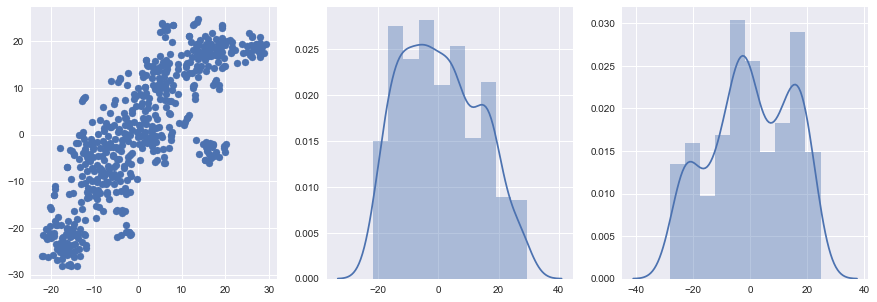

In [131]:
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(131)
ax.scatter(X[:,0],X[:,1])
ax = fig.add_subplot(132)
sns.distplot(X[:,0])
ax = fig.add_subplot(133)
sns.distplot(X[:,1])

In [89]:
# Identify the states (clusters)
max_states = 5
n_features = X.shape[1]

from sklearn import mixture

dpgmm = mixture.BayesianGaussianMixture(
    n_components=max_states, 
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    covariance_prior=1e0 * np.eye(n_features),
    init_params="random", tol=1e-6, max_iter=10000, n_init=1, 
    verbose=2, verbose_interval=100).fit(X)

Initialization 0
  Iteration 0	 time lapse 0.00613s	 ll change inf
  Iteration 100	 time lapse 0.17551s	 ll change 0.01260
Initialization converged: True	 time lapse 0.27868s	 ll -3044.23843


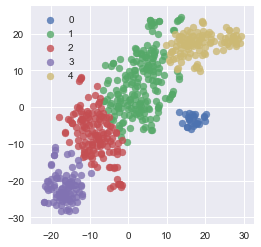

In [90]:
state_assignment = dpgmm.predict(X)
states = np.unique(state_assignment)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
for state in states:
    mask = state_assignment==state
    Xs = X[mask]
    ax.scatter(Xs[:,0], Xs[:,1], alpha=0.8, label=state)
    
plt.legend()

In [91]:
# Construct the state-time data frame
df_state = pd.DataFrame(
    data={'Time': df_copyNumber.index.get_level_values(level=1),
          'State': state_assignment
         })

col_dim = []
for i in range(d):
    df_state['Dim_'+str(i+1)] = X[:,i]
    col_dim.append('Dim_'+str(i+1))

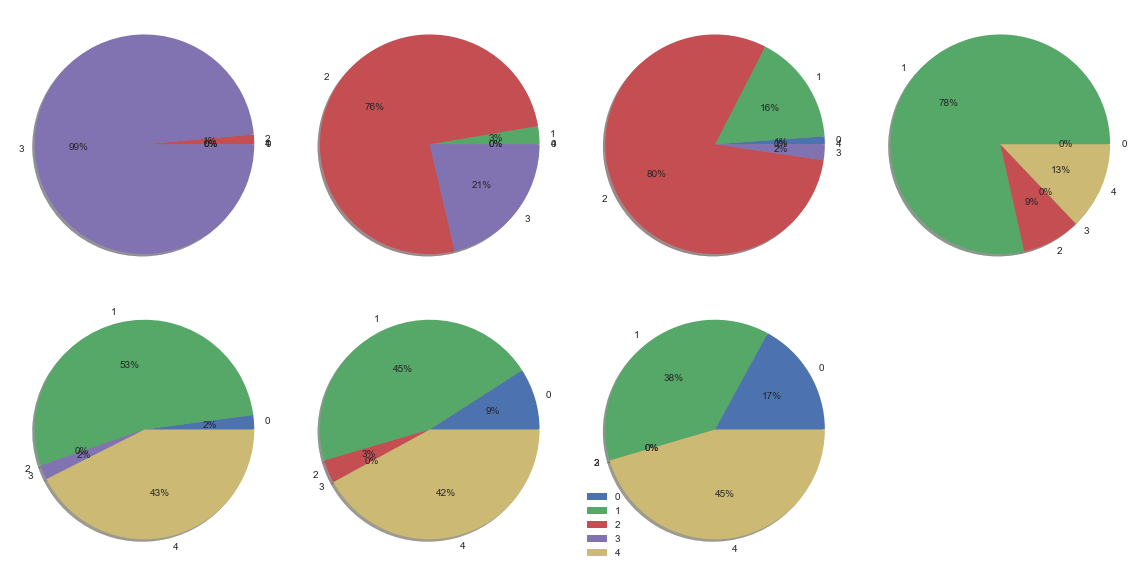

In [92]:
times = time_stamp.unique()

n_col = 4
n_time = times.shape[0]
n_row = n_time // n_col
n_row +=  n_time % n_col
pos = range(1, n_time+1)

fig = plt.figure(figsize=(4*n_col,4*n_row))
states_freq = []
for i, time in enumerate(times):
    mask = df_state['Time']==time
    state_dist = df_state[mask]['State'].values
    
    state_freq = []
    for state in states:
        state_freq.append((state_dist[state_dist==state]).shape[0])
    
    states_freq.append(state_freq)
    ax = fig.add_subplot(n_row, n_col, pos[i])
    #ax.hist(state_dist)
    #ax.set_ylim([0,70])
    ax.pie(state_freq, autopct='%.0f%%', labels=states, shadow=True)
    #ax.set_xticks(states)

plt.legend(loc='lower left')
plt.tight_layout()

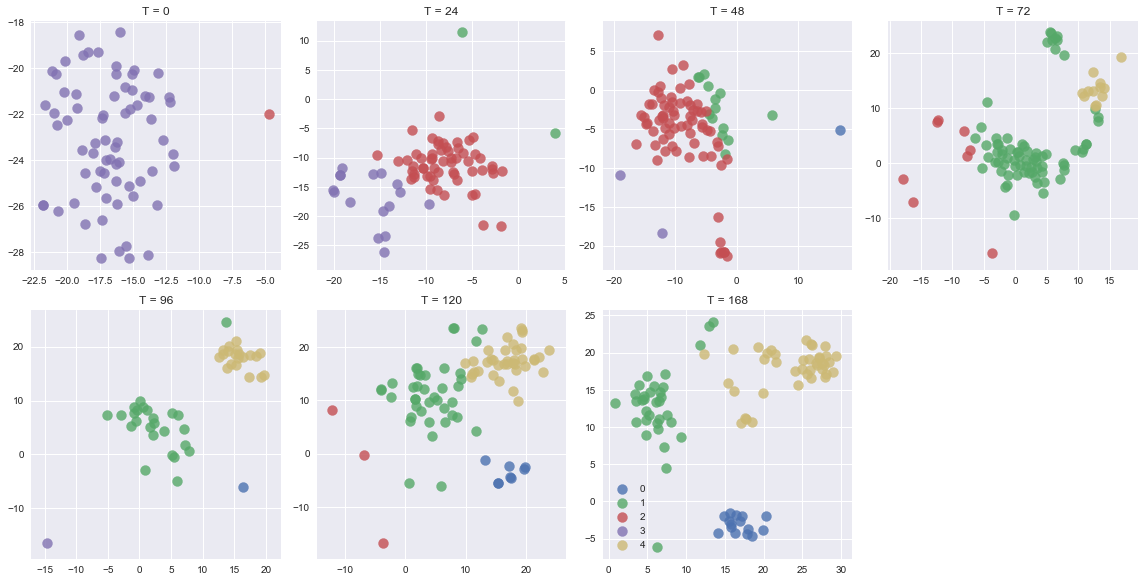

In [93]:
fig = plt.figure(figsize=(4*n_col,4*n_row))
for i, time in enumerate(times):
    ax = fig.add_subplot(n_row, n_col, pos[i])
    for state in states:
        mask = (state_assignment==state) & (df_state['Time']==time)
        data = df_state[mask][col_dim]
        ax.scatter(data.iloc[:,0], data.iloc[:,1], alpha=.8, label=state, s=100)
        ax.set_title('T = '+str(time))

plt.legend()
plt.tight_layout()

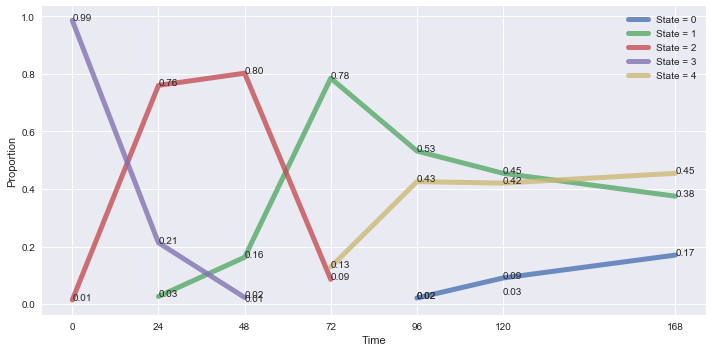

In [130]:
states_evl = np.array(states_freq)
states_evl_pct = []

for x in states_evl:
    states_evl_pct.append(x/x.sum())
    
states_evl_pct = np.array(states_evl_pct)
states_evl_pct[states_evl_pct<=0] = np.nan

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
for j in range(states_evl_pct.shape[1]):
    plt.plot(times, states_evl_pct[:,j], label='State = '+str(states[j]), linewidth=5, alpha=.8)
    for a,b in zip(times, states_evl_pct[:,j]):
        if not np.isnan(b):
            ax.annotate('{:.2f}'.format(b), xy=(a,b))
            
plt.xticks(times)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.tight_layout()